In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import tensorflow as tf
from tensorflow import keras


from numpy.random import seed
seed(2)
tf.random.set_seed(2)

In [2]:
#Create a function for loading and compiling grayscale images into a dataset
def load_dataset(datadir, categories, img_height, img_width):
    
    dataset = []
    
    #Iterate through all scene folders
    for cat in categories:
        # sets path to the individual categories
        path = os.path.join(datadir, cat)
        
        #Set label for each image (Target Variable)
        cat_num = categories.index(cat)
        
        #iterate through each image in each folder for each category
        for img in os.listdir(path):
            #join path to image and convert images to arrays
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_array2 = cv2.resize(img_array,(img_height, img_width))
            dataset.append([img_array2, cat_num])
    return dataset

In [3]:
#Set directory and load training data
traindir = "../input/intel-image-classification/seg_train/seg_train"
testdir = "../input/intel-image-classification/seg_test/seg_test"
classes = ["buildings", "forest", "glacier", "mountain", "sea", "street"]

In [4]:
#Load training and test datasets
train = load_dataset(traindir, classes, 150, 150)
test = load_dataset(testdir, classes, 150, 150)

#Observe size of datasets
len(train), len(test)

(14034, 3000)

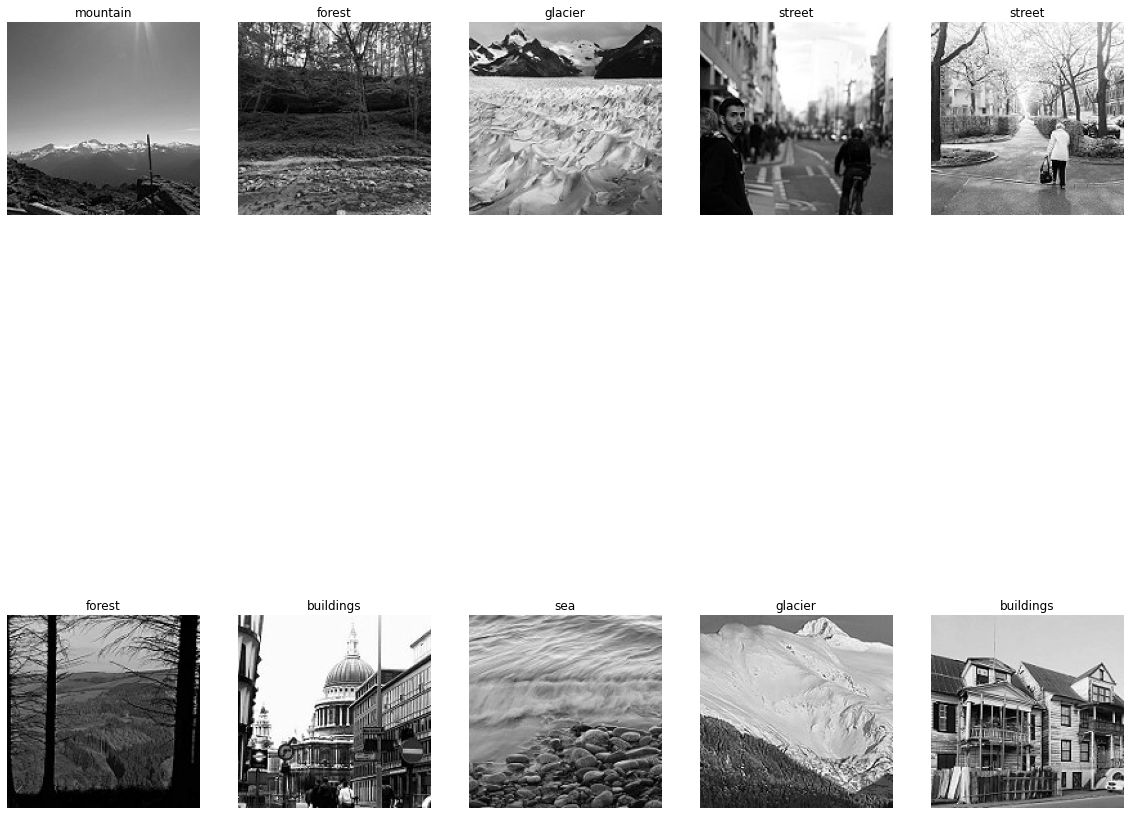

In [5]:
#Plot random images from training dataset and their labels
cate = {0: "buildings", 1: "forest", 2: "glacier", 3: "mountain", 4: "sea", 5: "street"}
fig, axes = plt.subplots(2, 5, figsize=(20, 20))
for i in range(0, 2):
    for j in range(0, 5):
        randint = np.random.randint(0, len(train))
        axes[i, j].imshow(train[randint][0], cmap = 'gray')
        axes[i, j].set_title(cate.get(train[randint][1]))
        axes[i,j].axis('off')


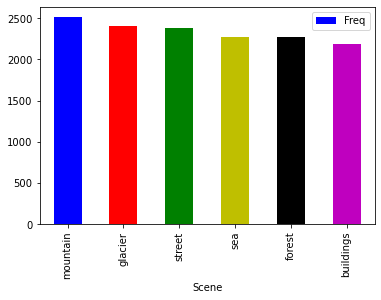

In [6]:
#Distribution of classes
distr = np.array(train)[:, 1]
df = pd.DataFrame(np.unique(distr, return_counts = True), columns = classes).drop(0).transpose().reset_index()
df.columns = ['Scene', 'Freq']
df.sort_values(by = 'Freq', ascending = False).plot.bar('Scene', 'Freq', color = ['b', 'r', 'g', 'y', 'k', 'm'])

In [7]:
#Shuffle data to create randomness
import random
random.shuffle(train)
random.shuffle(test)

In [8]:
def df_split(df):
    X = []
    y = []
    for feat, lab in df:
        X.append(feat)
        y.append(lab)
    return X, y

In [9]:
X, y = df_split(train)
X_test, y_test = df_split(test)

In [10]:
def input_shape(x, img_height, img_width, channels):
    x = np.array(x).reshape(-1, img_height, img_width, channels)
    return x

In [11]:
X = input_shape(X, 150, 150, 1)
X_test = input_shape(X_test, 150, 150, 1)

X.shape, X_test.shape

((14034, 150, 150, 1), (3000, 150, 150, 1))

In [12]:
y = np.array(y)
y_test = np.array(y_test)

In [13]:
#Save Test and Train Arrays
np.savez("train_x", X)
np.savez("train_y", y)


In [14]:
np.savez("test_x", X_test)
np.savez("test_y", y_test)

In [15]:
X[0]

array([[[187],
        [183],
        [181],
        ...,
        [213],
        [214],
        [214]],

       [[181],
        [178],
        [176],
        ...,
        [213],
        [212],
        [212]],

       [[176],
        [174],
        [173],
        ...,
        [211],
        [209],
        [208]],

       ...,

       [[ 11],
        [  8],
        [  6],
        ...,
        [ 26],
        [ 34],
        [ 66]],

       [[ 12],
        [  9],
        [  8],
        ...,
        [ 51],
        [ 43],
        [ 37]],

       [[  9],
        [  9],
        [ 12],
        ...,
        [ 22],
        [ 48],
        [ 45]]], dtype=uint8)

In [16]:
#find the maximum value of inputs
np.amax(X), np.amax(X_test)

(255, 255)

In [17]:
#Use the maximum value to scale the input values. This helps in training
X = X/255
X_test = X_test/255

In [19]:
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [20]:
#Split test set, into eval and prediction set
X_eval, X_predict, y_eval, y_predict = train_test_split(X_test, y_test, test_size = 0.20, random_state = 42)

In [21]:
#Creating/Building the model using the sequential API
model = keras.Sequential()

#We then build the Convolutional layers. Flatten layers role is to covnvert each input into a 1D array
model.add(keras.layers.Conv2D(32, 3, activation = "relu", input_shape = X[0].shape))
model.add(keras.layers.MaxPooling2D(2, strides = 2))

model.add(keras.layers.Conv2D(64, 3, activation = "relu", padding = "same"))
model.add(keras.layers.MaxPooling2D(2, strides = 2))

model.add(keras.layers.Conv2D(128, 3, activation = "relu", padding = "same"))
model.add(keras.layers.MaxPooling2D(2, strides = 2))

model.add(keras.layers.Conv2D(512, 3, activation = "relu", padding = "same"))
model.add(keras.layers.MaxPooling2D(2, strides = 2))
          

#flatten
model.add(keras.layers.Flatten())

#we then add a dense hidden layer with 300 neurons, using the relu activation function
model.add(keras.layers.Dense(300, activation = "relu"))

#finally we add a dense output layer with 10 neurons, one for class
model.add(keras.layers.Dense(6, activation = "softmax"))

In [22]:
#summary() method displays the model's layers, their names, their output shapes and number of parameters
model.summary()#

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 512)       5

In [23]:
#compiling the model
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics=["accuracy"])

In [27]:
#Training and evaluating the model
history = model.fit(X_train, y_train, epochs = 10, batch_size = 128, validation_data = (X_val, y_val))

Epoch 1/10
176/176 [==============================] - 7s 39ms/step - loss: 0.2535 - accuracy: 0.9052 - val_loss: 0.7832 - val_accuracy: 0.7912
Epoch 2/10
176/176 [==============================] - 6s 35ms/step - loss: 0.1811 - accuracy: 0.9348 - val_loss: 0.6955 - val_accuracy: 0.8083
Epoch 3/10
176/176 [==============================] - 6s 35ms/step - loss: 0.1239 - accuracy: 0.9559 - val_loss: 0.8111 - val_accuracy: 0.7966
Epoch 4/10
176/176 [==============================] - 6s 34ms/step - loss: 0.0569 - accuracy: 0.9825 - val_loss: 0.9969 - val_accuracy: 0.8058
Epoch 5/10
176/176 [==============================] - 6s 34ms/step - loss: 0.0551 - accuracy: 0.9808 - val_loss: 0.9350 - val_accuracy: 0.8094
Epoch 6/10
176/176 [==============================] - 6s 35ms/step - loss: 0.0414 - accuracy: 0.9876 - val_loss: 1.0065 - val_accuracy: 0.8115
Epoch 7/10
176/176 [==============================] - 6s 34ms/step - loss: 0.0466 - accuracy: 0.9846 - val_loss: 1.1851 - val_accuracy: 0.7916

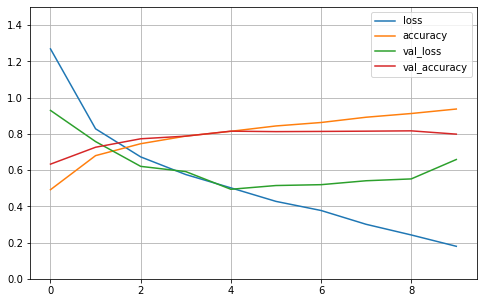

In [25]:
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)
plt.show()

In [26]:
model.evaluate(X_eval, y_eval)

75/75 [==============================] - 1s 7ms/step - loss: 0.7406 - accuracy: 0.7704


[0.7405584454536438, 0.7704166769981384]

In [ ]:
y_pred = model.predict_classes(X_predict)

In [ ]:
#print a classification report depicting the precision, recall, and f1-score of t=the different classes and overall model
from sklearn.metrics import classification_report
class_rep_rf = classification_report(y_predict, y_pred)
print(class_rep_rf)